# SMASAC - Data Collection

This notebook shows how to use the [Twitter API](https://developer.twitter.com/en/docs) for collecting data on twitter. We show how to use the [Tweepy library](http://tweepy.readthedocs.io/en/v3.6.0/) for collecting data, how to restrict search results and perform some basic visualisation and filtering of the collected data. This notebook is structured as follow:

1. OAuth and Tweepy configuration
2. Obtaining some data using the seach API
3. Using the streaming API
4. Clustering and Filtering

In [1]:
# Load .env file if it exists:
%load_ext dotenv
%dotenv api.env

# Import required libraries:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import requests
import folium
import os
import tweepy
import uuid
import json
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
from shapely.geometry import Point

## OAuth and Tweepy Configuration

Twitter and other social media platforms use a form of authentication called 'OAuth'. There are different types of authentification. In order to colect data, you need a Twitter account and generate four different access token (see [the API key generation tutorial](http://social-metrics.org/api-keys/)):

In [2]:
# Add your personal tokens below:
CONSUMER_KEY    = '<YOUR_CONSUMER_KEY>'
CONSUMER_SECRET = '<YOUR_CONSUMER_SECRET>'
ACCESS_TOKEN    = '<YOUR_ACCESS_TOKEN>'
TOKEN_SECRET    = '<YOUR_TOKEN_SECRET>'

# Load environment variables instead if they exists:
CONSUMER_KEY = os.environ.get('CONSUMER_KEY', CONSUMER_KEY)
CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET', CONSUMER_SECRET)
ACCESS_TOKEN = os.environ.get('ACCESS_TOKEN', ACCESS_TOKEN)
TOKEN_SECRET = os.environ.get('TOKEN_SECRET', TOKEN_SECRET)

In [4]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, TOKEN_SECRET)
api = tweepy.API(auth)

## Getting Some Data with the Search API
First we obtain some data using the basic Twitter seach API. Tweepy manages rate limits and other APIs limitations.
In order to find relevant tweets, we can use query parameters such as keywords or geolocation.


In [5]:
# Set some simple earthquake related keywords: 
keywords = ['earthquake', 'quake', 'magnitude', 'epicenter', 'magnitude', 'aftershock']

# Collect 100 tweets using the keywords:
search_results = api.search(q=' OR '.join(keywords), count=100)

Each Twitter message is encoded a JSON and contains multiple information besides its author and text:

In [6]:
if search_results is not []:
    # Print the first Tweet as JSON:
    print(json.dumps(search_results[0]._json, indent=2))

{
  "geo": null,
  "favorite_count": 0,
  "id_str": "988021502216843264",
  "metadata": {
    "result_type": "recent",
    "iso_language_code": "ja"
  },
  "id": 988021502216843264,
  "entities": {
    "symbols": [],
    "hashtags": [],
    "user_mentions": [
      {
        "screen_name": "ngcmk005",
        "name": "\u30d5\u30b8\u30e4\u30de \u3066\u308b\u516c",
        "indices": [
          3,
          12
        ],
        "id_str": "571598246",
        "id": 571598246
      }
    ],
    "urls": []
  },
  "retweeted_status": {
    "geo": null,
    "entities": {
      "symbols": [],
      "hashtags": [],
      "user_mentions": [],
      "urls": [
        {
          "indices": [
            117,
            140
          ],
          "expanded_url": "https://twitter.com/i/web/status/987898117780525056",
          "url": "https://t.co/pzMCOqiyAf",
          "display_url": "twitter.com/i/web/status/9\u2026"
        }
      ]
    },
    "id_str": "987898117780525056",
    "metadata": 

We can convert the data into a dataframe for simpliufying its manipulation as well as exporting it to CSV for further processing:

In [9]:
df = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text } for result in  search_results])[['id', 'created_at', 'user', 'text']]
display(df.head())

,id,created_at,user,text
0,988021502216843264,2018-04-22 11:47:37,@まちゃおじ,RT @ngcmk005: 【地震状況】 4月22日 気象庁発表の地震は、12時まで2回です...
1,988021476304543745,2018-04-22 11:47:31,@US Tribune News,"Earthquake hits 41km NE of Visokoi Island, Sou..."
2,988021466317795328,2018-04-22 11:47:28,@アン,RT @tenkijp_jishin: 22日20時36分頃、東京都で最大震度2を観測する地...
3,988021449972629506,2018-04-22 11:47:24,@声で本作りsmall world,RT @earthquake_jp: 【気象庁情報】22日 20時30分頃 新島・神津島近海...
4,988021447359680514,2018-04-22 11:47:24,@Noya Momose 百瀬直也,【地震情報】22日20:36 [ 最大震度 ] 震度 2 [ 震源地 ] 新島・神津島近海 ...


Bezsides using keywords, we can also restrict the results within a particular location and given language:

In [10]:
# What is the weather 500mm around Lyon?: 
keywords2 = ['weather' , 'forcast', 'sun', 'rain', 'clouds', 'storm']

# Only in english please !
lang = 'en'

# Get tweets around Lyon (latitide,longitude,radius):
geocode = '45.76,4.84,500km'

# Collect 1500 tweets using the keywords:
search_results2 = api.search(q=' OR '.join(keywords2), geocode=geocode, lang=lang, count=1500)


# Convert to GeoPandas:
df2 = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text, 'geometry': result.coordinates } for result in  search_results2])[['id', 'created_at', 'user', 'text', 'geometry']]
df2['geometry'] = df2['geometry'].apply(lambda coords: np.nan if coords is None else Point(coords['coordinates']))
df2 = df2.dropna() # Remove documents without geometry point (the twitter API may obtain location using user details rather than the tweet location.).
df2 = GeoDataFrame(df2, crs = {'init': 'epsg:2263'})

display(df2.head())

,id,created_at,user,text,geometry
1,988021547678892032,2018-04-22 11:47:48,@Montpellier Weather,"current weather in Montpellier: clear sky, 22°...",POINT (3.86 43.61)
4,988020934551289857,2018-04-22 11:45:21,@Lyon Weather,"current weather in Lyon: clear sky, 26°C\n31% ...",POINT (4.84 45.75)
7,988020676010196994,2018-04-22 11:44:20,@Marseille Weather,"current weather in Marseille: clear sky, 24°C\...",POINT (5.41 43.31)
14,988020239836241925,2018-04-22 11:42:36,@Geneva Weather,"current weather in Geneva: clear sky, 24°C\n44...",POINT (6.14 46.21)
21,988019312999854080,2018-04-22 11:38:55,@Monaco Weather,"current weather in Monaco: clear sky, 20°C\n72...",POINT (7.42 43.74)


We can now display the tweets on a map in order to see the weather around Lyon.
We can also do some basic keyword matching to display icons representing the weather:

In [11]:
# Create a map:
results2_map = folium.Map([45.76,4.84],
                  zoom_start=6,
                  tiles='Stamen Toner')

# Iterate over documents and add them the amp:
for index, document in tqdm_notebook(df2.iterrows()):
    
    # Perform very simple matching of words for displaying the weather:
    if 'sun' in document['text'].lower() or 'clear' in document['text'].lower():
        icon_img = 'sun-o'
        color = 'orange'
        
    elif 'rain' in document['text'].lower() or 'showers' in document['text'].lower():
        icon_img = 'umbrella'
        color = 'blue'
        
    elif 'strom' in document['text'].lower():
        icon_img = 'bolt'
        color = 'black'
    
    elif 'cloud' in document['text'].lower():
        icon_img = 'cloud'
        color = 'gray'
        
    else:
        icon_img = 'info-circle'
        color = 'green'
    
    icon = folium.Icon(color=color, icon_color='white', icon=icon_img, angle=0, prefix='fa')
    folium.Marker([document['geometry'].y, document['geometry'].x], popup=document['text'], icon=icon).add_to(results2_map)

display(results2_map)

## Streaming API
In order to obtain data in realtime as new data is produced, it is necessary to use the Twitter streaming API. In this section we show how to collect tweets using the streaming API.

The first step is to create a listener that will colect the tweet and store them. In a real pipeline the tweet may be passed to another process as they are collected rather than stored.

In [12]:
# Create listener:
class TwitterStreamListener(tweepy.StreamListener):
    
    def __init__(self, api=None, max_count=1000):
        super(TwitterStreamListener, self).__init__(api)
        
        self.max_count = max_count
        self.count = 0
        self._data = []
        
        if self.max_count is not None:
            self._pbar = tqdm_notebook(total=self.max_count, desc='Collecting tweets.')
            self._pbar.clear()
      
    # Retrun the data as a dataframe:
    @property
    def data(self):
        results = self._data
        df = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text, 'geometry': result.coordinates } for result in  results])[['id', 'created_at', 'user', 'text', 'geometry']]
        df['geometry'] = df['geometry'].apply(lambda coords: np.nan if coords is None else Point(coords['coordinates']))
        df = GeoDataFrame(df, crs = {'init': 'epsg:2263'})
        
        return df
        
        
    # Do something when a tweet is received:
    def on_status(self, status):
        
        # Stop collecting when max_count is reached:
        self.count = self.count + 1
        #print(str(self.count) + ': ' + status.text)
        self._data.append(status)
        
        if self.max_count is not None:
            self._pbar.update()

            if self.count == self.max_count:
                self._pbar.close()
                return False
       

We collect 10 tweets using the twitter API and convert it to a dataframe:

In [14]:
# Create a stream listener that collect 10 tweet:
stream_listener = TwitterStreamListener(max_count=10)
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

# Get earthquake related information:
keywords3 = ['earthquake', 'quake', 'magnitude', 'epicenter', 'magnitude', 'aftershock']

# Go fetch:
stream.filter(track=keywords3)
display(stream_listener.data.head())

,id,created_at,user,text,geometry
0,988022034620862464,2018-04-22 11:49:44,@Chintamoni Mallick,RT @Kill_BillPandey: Aise logo ke liye sarkar ...,NaN
1,988022066501730304,2018-04-22 11:49:51,@しがない産婦人科医,RT @tenkijp_jishin: 22日20時36分頃、東京都で最大震度2を観測する地...,NaN
2,988022076962365440,2018-04-22 11:49:54,@raa.,RT @justforwanna1: [HQ] 180421 Kang Daniel\nCr...,NaN
3,988022088584908800,2018-04-22 11:49:57,@My Earthquake Alerts,"1.86 earthquake occurred 1km NNE of Pahala, Ha...",NaN
4,988022117588287488,2018-04-22 11:50:04,@ツイトク.JP,RT @tenkijp_jishin: 22日20時36分頃、東京都で最大震度2を観測する地...,NaN


## Loading the CrisisLexT26 Datasets
In this tutorial we rely on the [CrisisLexT26 corpus](http://crisislex.org/data-collections.html#CrisisLexT26). CrisisLexT26 is a dataset that contains Tweets from 26 crises, labeled by informativeness, information type and source. The collection includes tweets collected during 26 large crisis events in 2012 and 2013, with about 1,000 tweets labeled per crisis for informativeness (i.e. “informative," or "not informative"), information type, and source.

In this section we  concatenate all the flood events :

In [22]:
files = {
 'Philipinnes floods': '../data/2-data-collection/2012_Philipinnes_floods-tweets_labeled.csv',    
 'Alberta floods': '../data/2-data-collection/2013_Alberta_floods-tweets_labeled.csv',
 'Colorado floods': '../data/2-data-collection/2013_Colorado_floods-tweets_labeled.csv',
 'Manila floods': '../data/2-data-collection/2013_Manila_floods-tweets_labeled.csv',  
 'Queensland floods': '../data/2-data-collection/2013_Queensland_floods-tweets_labeled.csv',
 'Sardinia floods': '../data/2-data-collection/2013_Sardinia_floods-tweets_labeled.csv' }

frames = []
for event, f in tqdm_notebook(files.items(), desc='Fetch data'):
    frames.append(pd.read_csv(f))
    
data = pd.concat(frames, keys=files.keys())
display(data.head())

Tweet ID  \
Colorado floods 0  376843697943769088   
                1  378011169883037697   
                2  378020179214491649   
                3  378026101588496385   
                4  378029784204206080   

                                                          Tweet Text  \
Colorado floods 0  #Longmont #CO The Tiny Tim Center is now #hiri...   
                1  RT @dlfluegge: Crazy Flooding in Boulder, Colo...   
                2  Here's the #boulderflood video that's circulat...   
                3  RT @passantino: Video: Severe flooding hits ne...   
                4  Crazy Flooding in Boulder, Colorado http://t.c...   

                   Information Source          Information Type  \
Colorado floods 0         Not labeled               Not labeled   
                1               Media      Sympathy and support   
                2           Outsiders  Other Useful Information   
                3               Media  Other Useful Information   
                4               Media  Other Useful Information   

                                 Informativeness  
Colorado floods 0                    Not related  
                1  Related - but not informative  
                2        Related and informative  
                3        Related and informative  
                4        Related and informative

### Clustering and Filtering

Although the data has been manually annotated, lets ignore this information for the moment. We will use this information later on when trainning text classifiers.
We can use off-the shelf tools for clustering the data. 

For example, we can use topic models for clustering the data into topics automatically:

In [23]:
# Load sklearn and LDA (Latent Dirichlet Allocation):
from sklearn.decomposition import LatentDirichletAllocation

# Load word tokenisers and vectorisers:
from sklearn.feature_extraction.text import CountVectorizer

Before fitting an LDA model, we need to tokenise the data so each document is represented as word vectors (i.e., a vector that indicates how many instance of a word is in a document for each document). Later on in this tutorial we will invetigate other document representation using word embeddings.

In [24]:
# We split each documents by words using the default Sklearn tokenizer:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
vects = count_vectorizer.fit_transform(data[' Tweet Text'])
vocabulary = count_vectorizer.get_feature_names()

# How many tokens?:
print('Vocabulary size: '+str(len(vocabulary)))

Vocabulary size: 5793


In [25]:
# We want to extract 5 topics:
nb_topics = 5
lda = LatentDirichletAllocation(n_components=nb_topics, learning_method='batch', random_state=42)


# We fit the model to the textual data: 
lda.fit(vects)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

Lets have a look at the topics extracted by LDA by displaying the top words for each topic:

In [26]:
n_top_words = 30
topic_words = {}

# Get the top words for each topic:
for topic, comp in enumerate(lda.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    topic_words['Topic #'+str(topic)] = [vocabulary[i] for i in word_idx]
    
topic_words = pd.DataFrame.from_dict(topic_words)
display(topic_words)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4
0,bigwet,rt,http,sardegna,http
1,rt,rescueph,floods,rt,rt
2,http,http,rt,http,flooding
3,qldfloods,reliefph,maringph,di,flood
4,na,help,colorado,la,floods
5,rescueph,need,manila,alluvione,colorado
6,qld,amp,flooding,il,yycflood
7,floodph,pls,sa,allertameteosar,coflood
8,maringph,flood,red,reliefph,abflood
9,flood,water,sardinia,le,calgary


Since the dataset is relatively small, the topics are not really well distributed. 
However we can see that the topics closely mach each event instance but have some sub-topics as well. For example, Topic 1 seems to be about needs and volunteering and topic 2 about victims.

Using those keywords we can set the following names for each topic:

In [28]:
topics = ['thoughts', 'needs_and_volunteering', 'victims', 'donnations', 'floods']
topic_words.columns = topics
display(topic_words.head())

,thoughts,needs_and_volunteering,victims,donnations,floods
0,bigwet,rt,http,sardegna,http
1,rt,rescueph,floods,rt,rt
2,http,http,rt,http,flooding
3,qldfloods,reliefph,maringph,di,flood
4,na,help,colorado,la,floods


Using the previous topics, we can no associate a label to each document show the distribution of topics in a given dataset.
For the Queensland floods, we have the following topic distribution:

In [29]:
queensland_data = pd.read_csv('../data/2-data-collection/2013_Queensland_floods-tweets_labeled.csv')
topic_preds = [topics[p] for p in np.argmax(lda.transform(count_vectorizer.transform(queensland_data[' Tweet Text'])), axis=1)]

We can also plot the distribution in order to better understand the situation:

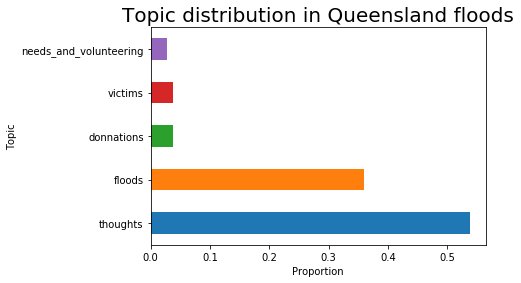

In [30]:
pd.Series(topic_preds).value_counts(normalize=True).plot.barh()
plt.title('Topic distribution in Queensland floods', fontsize=20)
plt.xlabel('Proportion')
plt.ylabel('Topic')
plt.show()

Given the data distribution we can now focus on particular topic of interres. For example we want to see what documents are mentionning victims:

In [32]:
classified_queensland_data = queensland_data.assign(topic=topic_preds)
classified_queensland_data.loc[classified_queensland_data['topic'] == 'victims']

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,topic
34,294609615847571456,Queensland floods as cyclone sweeps past http:...,Outsiders,Other Useful Information,Related and informative,victims
46,294720559403651072,VIDEO: Tropical storm strikes Queensland: Trop...,Media,Other Useful Information,Related and informative,victims
47,294720815243612160,VIDEO: Tropical storm strikes Queensland: Trop...,Outsiders,Other Useful Information,Related and informative,victims
97,295085275087003648,Severe Weather Warning issued for #Scenicrim #...,Media,Caution and advice,Related and informative,victims
207,295409335432007682,Queensland braces for flooding: The Australian...,Media,Caution and advice,Related and informative,victims
208,295409385772044288,Queensland braces for flooding: The Australian...,Outsiders,Caution and advice,Related and informative,victims
225,295419355632635904,RT @AustralianNews: Queensland records first f...,Media,Affected individuals,Related and informative,victims
348,295480454025465856,@craiglowndes888 So you're missing out on the...,Outsiders,Other Useful Information,Related - but not informative,victims
367,295490268705193985,A person have to see this. Can't cease laughi...,Not labeled,Not labeled,Not related,victims
368,295491501822197760,http://t.co/uwJfTLgB Launch me personally from...,Not labeled,Not labeled,Not related,victims
